In [8]:
using NBInclude

@nbinclude("julia_function.ipynb")

allskyts (generic function with 1 method)

In [9]:
# Defining oscillation probability function with distinct mass splitting values

function oscprobdistinct(et, dm21, dm22, dm23, leff)

    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    osc1 = (cos((dm21 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm22 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm23 * leff)/(4*et*1e12)))^2

    prob_surv = osc1*(u[1]*u[1]) + osc2*(u[4]*u[4]) + osc3*(u[7]*u[7])
    prob_mue = osc1*(u[1]*u[2]) + osc2*(u[4]*u[5]) + osc3*(u[7]*u[8])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

oscprobdistinct (generic function with 1 method)

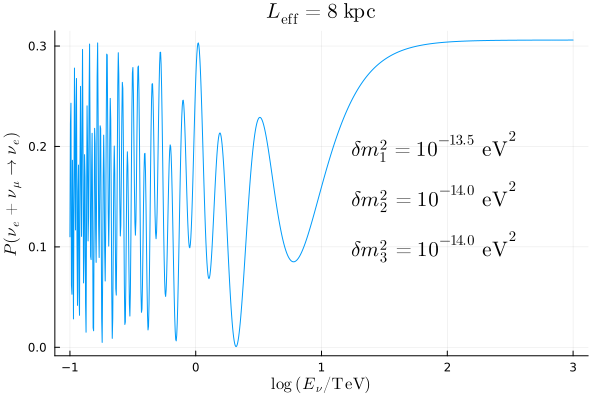

In [3]:
# Plotting the new oscillation probabilities

dm2s = (10^(-13.5), 10^(-14), 10^(-14))

leff = 8

us = range(-1, 3, 1000)
es = 10 .^ us

oscprobs = oscprobdistinct.(es, dm2s[1], dm2s[2], dm2s[3], leff)

plot(
    us,
    oscprobs,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{e} + \nu_{\mu} \to \nu_{e})",
    ann=[(1.9, 0.2, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 0.15, L"\delta m_2^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 0.1, L"\delta m_3^2 = 10^{-14.0}~\mathrm{eV}^2")],
    label=false,
    title=L"L_{\mathrm{eff}} = 8~\mathrm{kpc}"
)

In [10]:
# Redefining event distribution functions

function smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprobdistinct.(et, dm21, dm22, dm23, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = Interpolations.interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinneddistinct (generic function with 1 method)

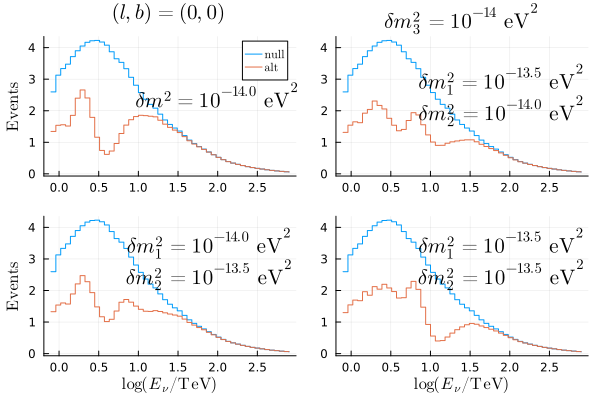

In [5]:
# Plotting the new event distributions

dm2s = (10^(-14), 10^(-14), 10^(-14))
dm2s1 = (10^(-13.5), 10^(-14), 10^(-14))
dm2s2 = (10^(-14), 10^(-13.5), 10^(-14))
dm2s3 = (10^(-13.5), 10^(-13.5), 10^(-14))

ubins = range(log10(emin), log10(emax), length=50)

distbins = edistbinneddistinct(dm2s[1], dm2s[2], dm2s[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins1 = edistbinneddistinct(dm2s1[1], dm2s1[2], dm2s1[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins2 = edistbinneddistinct(dm2s2[1], dm2s2[2], dm2s2[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins3 = edistbinneddistinct(dm2s3[1], dm2s3[2], dm2s3[3], 0, 0, 0.01, 0.122, 21.8, 2.7)


distbinsnull = edistbinneddistinct(0.0, 0.0, 0.0, 0, 0, 0.01, 0.122, 21.8, 2.7)

p0 = plot(
    ubins,
    [distbinsnull distbins],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"(l, b) = (0, 0)",
    ann=[(2, 2.5, L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2")]
)

p1 = plot(
    ubins,
    [distbinsnull distbins1],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    title=L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 2, L"\delta m_2^2 = 10^{-14.0}~\mathrm{eV}^2")]
)

p2 = plot(
    ubins,
    [distbinsnull distbins2],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    # title=L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3.5, L"\delta m_1^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 2.5, L"\delta m_2^2 = 10^{-13.5}~\mathrm{eV}^2")]
)

p3 = plot(
    ubins,
    [distbinsnull distbins3],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    # title=L"\delta m_2^2 = \delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3.5, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 2.5, L"\delta m_2^2 = 10^{-13.5}~\mathrm{eV}^2")]
)

plot(p0, p1, p2, p3, layout=(2, 2))

In [27]:
# Redefined the likelihood functions

function negloglhdistinct(dm21, dm22, dm23, l, b, θ, ϕ₀, γ, σ)

    nullhyp = edistbinneddistinct(0, 0, 0, l, b, σ, θ, 21.8, 2.7)
    althyp = edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end


function maxlhdistinct(dm21, dm22, dm23, l, b)

    θ = 0.122
    σ = 0.01

    function nllh(test)
        return negloglhdistinct(dm21, dm22, dm23, l, b, θ, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrtbinneddistinct(dm21, dm22, dm23, l, b)
    minim = maxlhdistinct(dm21, dm22, dm23, l, b)

    params = Optim.minimizer(minim)

    null = edistbinneddistinct(0, 0, 0, l, b, 0.01, 0.122, 21.8, 2.7)
    alt = edistbinneddistinct(dm21, dm22, dm23, l, b, 0.01, 0.122, params[1], params[2])

    ts = lrt(null, alt)
end

function maxlhdistinct_free_eres(dm21, dm22, dm23, l, b, σ)

    θ = 0.122

    function nllh(test)
        return negloglhdistinct(dm21, dm22, dm23, l, b, θ, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrtbinneddistinct_free_eres(dm21, dm22, dm23, l, b, σ)
    minim = maxlhdistinct_free_eres(dm21, dm22, dm23, l, b, σ)

    params = Optim.minimizer(minim)

    null = edistbinneddistinct(0, 0, 0, l, b, σ, 0.122, 21.8, 2.7)
    alt = edistbinneddistinct(dm21, dm22, dm23, l, b, σ, 0.122, params[1], params[2])

    ts = lrt(null, alt)
end

lrtbinneddistinct_free_eres (generic function with 1 method)

In [30]:
eress = range(0.01, 0.5, 100)

lrts_free_eres = [lrtbinneddistinct_free_eres(10^(-14), 10^(-14), 10^(-14), 0, 0, eres) for eres in eress]

100-element Vector{Float64}:
 17.149270144425248
 19.665324653508826
 19.847380648983012
 19.79610896690708
 19.725434530164605
 19.64346983818656
 19.550656705361263
 19.44738821721173
 19.334082970636214
 19.21118399996807
 19.079156364754034
 18.938484486162906
 18.789669447834143
  ⋮
  7.967730737806955
  7.9115148296150934
  7.856696590601044
  7.803236502493936
  7.75109652838229
  7.700239434348163
  7.650629461848165
  7.6022318557838275
  7.555012928639234
  7.508940062361739
  7.463981652715303
  7.420107138101629

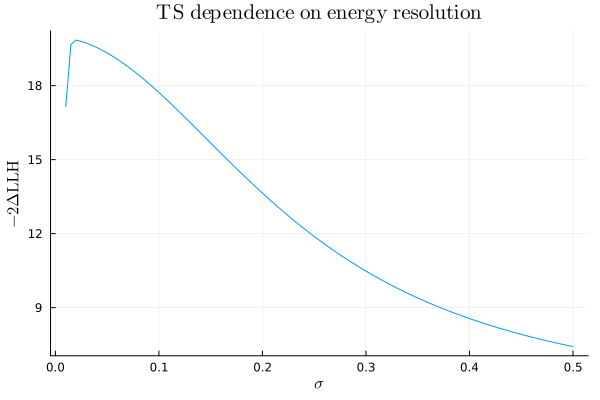

In [32]:
plot(
    eress,
    lrts_free_eres,
    xlabel=L"\sigma",
    ylabel=L"-2\Delta\mathrm{LLH}",
    label=false,
    title=L"\mathrm{TS~dependence~on~energy~resolution}"
)

In [16]:
# Calculating sensitivities for different distinct mass splittings

logdm23s = range(-15, -13, 50)
logdm22s = range(-15, -13, 50)

dm21 = 10^(-14)
dm22s = 10 .^ logdm22s
dm23s = 10 .^ logdm23s

teststatsdistinct = [lrtbinneddistinct(dm21, dm22, dm23, 0, 0) for dm23 in dm23s, dm22 in dm22s]


50×50 Matrix{Float64}:
 2.6681   2.63039  2.5965   2.56974  …  5.47288  5.4618   5.48568  5.4733
 2.66481  2.62767  2.5945   2.5686      5.46271  5.45177  5.47579  5.46351
 2.66114  2.62465  2.59227  2.56731     5.45154  5.44076  5.46494  5.45276
 2.65714  2.62134  2.5898   2.56587     5.43956  5.42896  5.45331  5.44126
 2.65286  2.61777  2.58711  2.56426     5.42711  5.4167   5.44126  5.42934
 2.64841  2.61401  2.58422  2.56245  …  5.41474  5.40454  5.42932  5.41754
 2.64393  2.61017  2.58118  2.56041     5.40326  5.39326  5.41828  5.40665
 2.63968  2.60642  2.57808  2.55812     5.39378  5.38398  5.40926  5.39777
 2.63601  2.60302  2.57505  2.55562     5.38776  5.37814  5.40368  5.39232
 2.63338  2.60035  2.57238  2.55303     5.38702  5.37754  5.40334  5.3921
 2.63249  2.59899  2.57052  2.55067  …  5.39368  5.38428  5.41033  5.39917
 2.63422  2.59975  2.5702   2.54917     5.41     5.40062  5.42689  5.41577
 2.63962  2.60369  2.57245  2.54951     5.43811  5.42867  5.45512  5.44398
 ⋮  

In [91]:
# Saving the array

# writedlm("misc_data/distinct_dm2_vals_001_res.txt", teststatsdistinct)

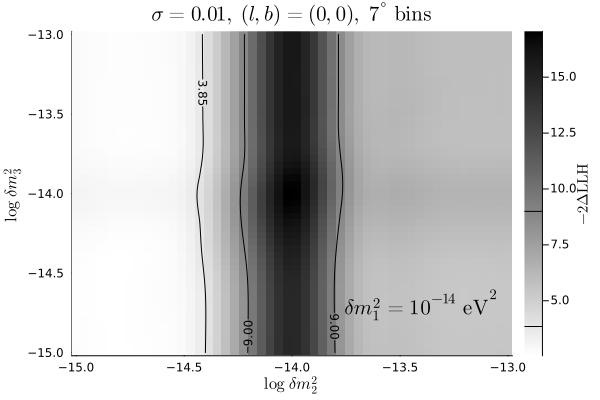

In [23]:
# Plotting the data

plot(
    logdm22s,
    logdm23s,
    teststatsdistinct,
    c=:grayC,
    xlabel=L"\log~\delta m_2^2",
    ylabel=L"\log~\delta m_3^2",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    title=L"\sigma = 0.01,~(l, b) = (0, 0),~7^{\circ}~\mathrm{bins}",
    ann=[(-13.4, -14.7, L"\delta m_1^2 = 10^{-14}~\mathrm{eV}^2")],
    seriestype=:heatmap,
    # interpolate=true
)

plot!(
    logdm22s,
    logdm23s,
    teststatsdistinct,
    levels=[3.85, 9.00],
    c=:black,
    clabels=true
)

In [92]:
# Saving the plot

# savefig("misc_plots/distinct_dm2_vals_001_res.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/distinct_dm2_vals_001_res.png"